In [1]:
pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU langchain-elasticsearch

Note: you may need to restart the kernel to use updated packages.


In [4]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
from langchain_community.embeddings.dashscope import DashScopeEmbeddings
import os

embeddings = DashScopeEmbeddings(
    model="text-embedding-v2",  # DashScope 的文本嵌入模型
    dashscope_api_key=os.getenv("DASHSCOPE_API_KEY")
)

# 生成单个文本的嵌入向量
query_result = embeddings.embed_query("你好，世界！")
print(f"查询嵌入维度: {len(query_result)}")  # 输出: 1536（根据模型不同可能变化）

# 生成多个文档的嵌入向量
docs_result = embeddings.embed_documents([
    "这是第一个文档",
    "这是第二个文档"
])
print(f"文档嵌入数量: {len(docs_result)}")  # 输出: 2

查询嵌入维度: 1536
文档嵌入数量: 2


elasticsearch involve

In [ ]:
from langchain_elasticsearch import ElasticsearchStore

lastic_vector_search = ElasticsearchStore(
    es_url="http://localhost:9200",
    index_name="langchain_index",
    embedding=embeddings,
    es_user="elastic",
    es_password="qJf8HCfD",
)e

In [19]:
from uuid import uuid4

from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocolate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)

documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))]

elastic_vector_search.add_documents(documents=documents, ids=uuids)

['5e3bc7a3-941d-47c5-8fc7-7cfcc011cbbf',
 '548fe5d9-cc85-4337-9626-f302fdd82771',
 '3c4c8057-67c5-4d62-b088-90adf6cd4caf',
 'b59a0c26-9f84-4172-907f-8d2fe742fde4',
 '3d616307-17dd-4f80-9800-5f36432172c9',
 '183ca00e-83a6-4b90-8bec-bf08e0175e59',
 '95c4c220-ee0f-476f-aec8-931577f06ca6',
 '982311dc-7f1a-43db-9409-0a8f5301789c',
 'c8ae53e4-1337-411e-bef9-1f1a8152d377',
 '5204adb3-434f-4cde-a754-b8e90b640a47']

In [ ]:
results = elastic_vector_search.similarity_search(
    query="LangChain provides abstractions to make working with LLMs easy",
    k=2,
    filter=[{"term": {"metadata.source.keyword": "tweet"}}],
)
results
# for res in results:
#     print(f"* {res.page_content} [{res.metadata}]")

[Document(metadata={'source': 'tweet'}, page_content='Building an exciting new project with LangChain - come check it out!'),
 Document(metadata={'source': 'tweet'}, page_content='LangGraph is the best framework for building stateful, agentic applications!')]

In [5]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [8]:
len(doc_splits)

538

In [27]:
vectorstore = ElasticsearchStore.from_documents(
    es_url="http://localhost:9200",
    index_name="langchain_index",
    es_user="elastic",
    es_password="qJf8HCfD",
    documents=doc_splits, 
    embedding=embeddings
)

In [29]:
retriever = vectorstore.as_retriever()

In [30]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [31]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Amodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nPan et al. (2022) investigated reward hacking as a function of agent capabilities, including (1) model size, (2) action space resolution, (3) observation space noise, and (4) training time. They also proposed a taxonomy of three types of misspecified proxy rewards:\n\nReward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward

In [ ]:
# https://python.langchain.com/docs/integrations/chat/tongyi/
from langchain.chat_models import ChatOpenAI  # 兼容OpenAI接口的Chat模型
from langchain.schema import HumanMessage, SystemMessage
from langchain_community.chat_models.tongyi import ChatTongyi
from langchain_core.messages import HumanMessage

llm = ChatTongyi(model="qwen-turbo")

llm_with_tools = llm.bind_tools([retriever_tool])

In [40]:
llm_with_tools.invoke("types of reward hacking")

AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'name': 'retrieve_blog_posts', 'arguments': '{"query":"types of reward hacking"}'}, 'index': 0, 'id': 'call_39f62fa1a1d544d7b29be1', 'type': 'function'}]}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'tool_calls', 'request_id': 'a18eda53-92e8-9f44-8b36-769996203fd9', 'token_usage': {'input_tokens': 184, 'output_tokens': 20, 'total_tokens': 204, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--6d131e13-332f-44a3-8dec-5ff363250c23-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of reward hacking'}, 'id': 'call_39f62fa1a1d544d7b29be1', 'type': 'tool_call'}])

In [42]:
from langgraph.graph import MessagesState

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        llm_with_tools.invoke(state["messages"])
    )
    return {"messages": [response]}

In [43]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [44]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_ac5cb2a5c0b84e37aa7a18)
 Call ID: call_ac5cb2a5c0b84e37aa7a18
  Args:
    query: types of reward hacking


In [74]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )
grader_model = ChatTongyi(model="qwen-turbo")

def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print('score', score)

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [53]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm_with_tools.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [54]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm_with_tools.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [75]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
# workflow.add_node(grade_documents)
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

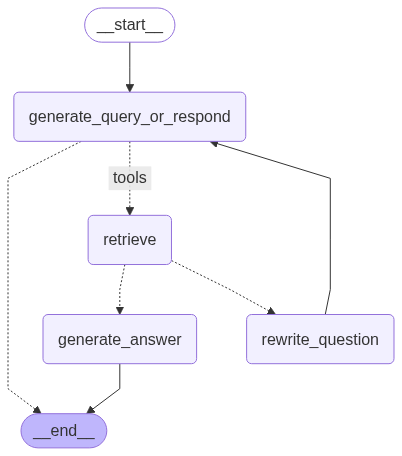

In [76]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
graph.invoke(
             {
        "messages": [
            {
                "role": "user",
                "content": "今天天气怎么样",
            }
        ]
    })

{'messages': [HumanMessage(content='今天天气怎么样', additional_kwargs={}, response_metadata={}, id='2901cace-4222-4758-ae70-cf9773655596'),
  AIMessage(content='抱歉，我无法提供天气信息。你可以查看天气预报或者使用相关应用查看今天的天气情况。', additional_kwargs={}, response_metadata={'model_name': 'qwen-turbo', 'finish_reason': 'stop', 'request_id': '7aac7a30-cdd8-9250-9c4a-c8647d9a7b31', 'token_usage': {'input_tokens': 183, 'output_tokens': 20, 'total_tokens': 203, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--7e25e7cc-2ea2-4728-9978-e3022c57fdb6-0')]}

In [77]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        try:
            update["messages"][-1].pretty_print()
        except:
            update["messages"][-1]
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_b36c54eef6d44520b967c6)
 Call ID: call_b36c54eef6d44520b967c6
  Args:
    query: types of reward hacking



score no
Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Amodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Pan et al. (2022) investigated reward hacking as a function of agent capabilities, including (1) model size, (2) action space resolution, (3) observation space noise, and (4) training time. They